# Fake News Detection (Traditional ML, No Ensemble)
Concise workflow for loading data, preprocessing text, training classical models, and evaluating results.

## 1. Import Libraries & Setup

In [1]:
import pandas as pd
import numpy as np
import re
import warnings
import time
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

## 2. Data Loading & Exploration

In [2]:
real_news_1 = pd.read_csv('True.csv')
fake_news_1 = pd.read_csv('Fake.csv')

real_news_1['label'] = 1
fake_news_1['label'] = 0

required_cols = ['title', 'text', 'label']
real_news_1 = real_news_1[required_cols]
fake_news_1 = fake_news_1[required_cols]

df_welfake = pd.read_csv('WELFake_Dataset.csv')

if 'news_label' in df_welfake.columns:
    df_welfake = df_welfake.rename(columns={'news_label': 'label'})

df_welfake = df_welfake[required_cols]
df_welfake['label'] = 1 - df_welfake['label']

real_news_2 = df_welfake[df_welfake['label'] == 1].copy()
fake_news_2 = df_welfake[df_welfake['label'] == 0].copy()

all_data = [real_news_1, fake_news_1, real_news_2, fake_news_2]
df = pd.concat(all_data, ignore_index=True)

df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df = df.sample(frac=1, random_state=123).reset_index(drop=True)

df['full_text'] = df['title'].fillna('') + ' ' + df['text'].fillna('')
df = df[df['full_text'].str.strip() != ''].reset_index(drop=True)

## 3. Dataset Analysis & Visualization

### 3.1 Dataset Information

In [ ]:
# Display dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117032 entries, 0 to 117031
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   title      116474 non-null  object
 1   text       116993 non-null  object
 2   label      117032 non-null  int64 
 3   full_text  117032 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.6+ MB


### 3.2 Class Imbalance Analysis

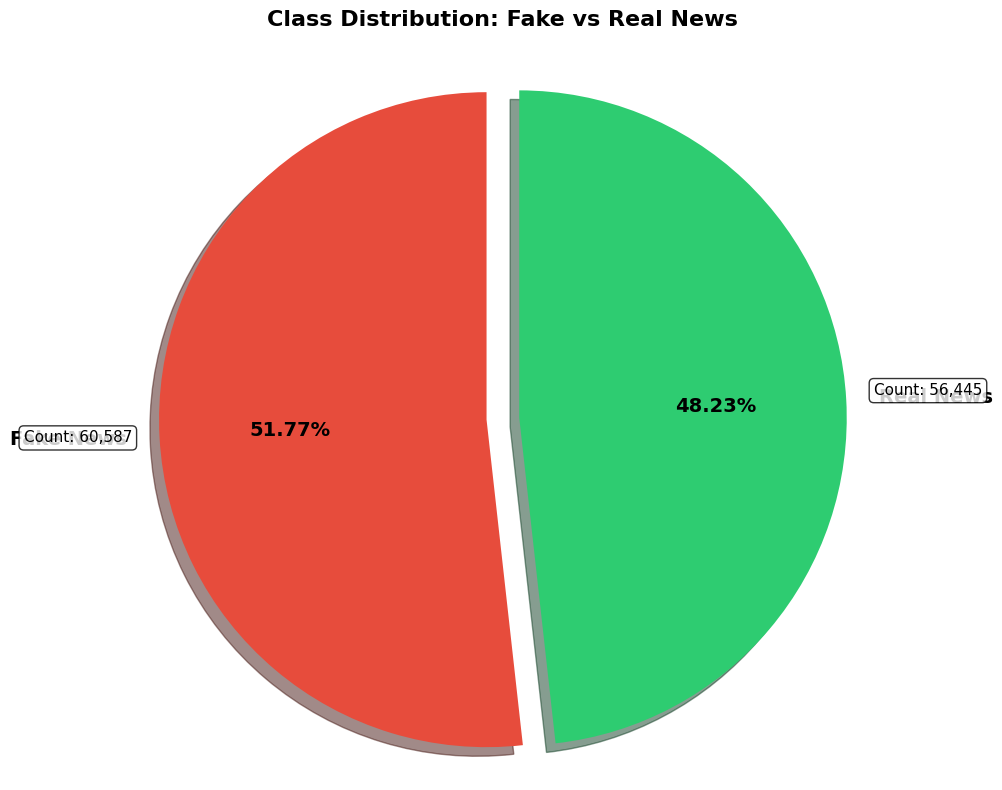

In [4]:
fake_count = (df['label'] == 0).sum()
real_count = (df['label'] == 1).sum()
total_count = len(df)

fake_percent = (fake_count / total_count) * 100
real_percent = (real_count / total_count) * 100

plt.figure(figsize=(10, 8))
colors = ['#e74c3c', '#2ecc71']
explode = (0.05, 0.05)

wedges, texts, autotexts = plt.pie(
    [fake_count, real_count],
    labels=['Fake News', 'Real News'],
    autopct='%1.2f%%',
    startangle=90,
    colors=colors,
    explode=explode,
    shadow=True,
    textprops={'fontsize': 14, 'fontweight': 'bold'}
)

plt.title('Class Distribution: Fake vs Real News\n', fontsize=16, fontweight='bold')

for i, (wedge, count) in enumerate(zip(wedges, [fake_count, real_count])):
    angle = (wedge.theta2 - wedge.theta1) / 2. + wedge.theta1
    x = np.cos(np.radians(angle))
    y = np.sin(np.radians(angle))
    label = f'Count: {count:,}'
    plt.annotate(label, xy=(x*1.3, y*1.3), fontsize=11, ha='center', 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

plt.axis('equal')
plt.tight_layout()
plt.show()

### 3.3 Word Cloud Visualizations

In [5]:
try:
    from wordcloud import WordCloud
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'wordcloud'])
    from wordcloud import WordCloud

real_news_text = ' '.join(df[df['label'] == 1]['full_text'].astype(str))
fake_news_text = ' '.join(df[df['label'] == 0]['full_text'].astype(str))
all_text = ' '.join(df['full_text'].astype(str))

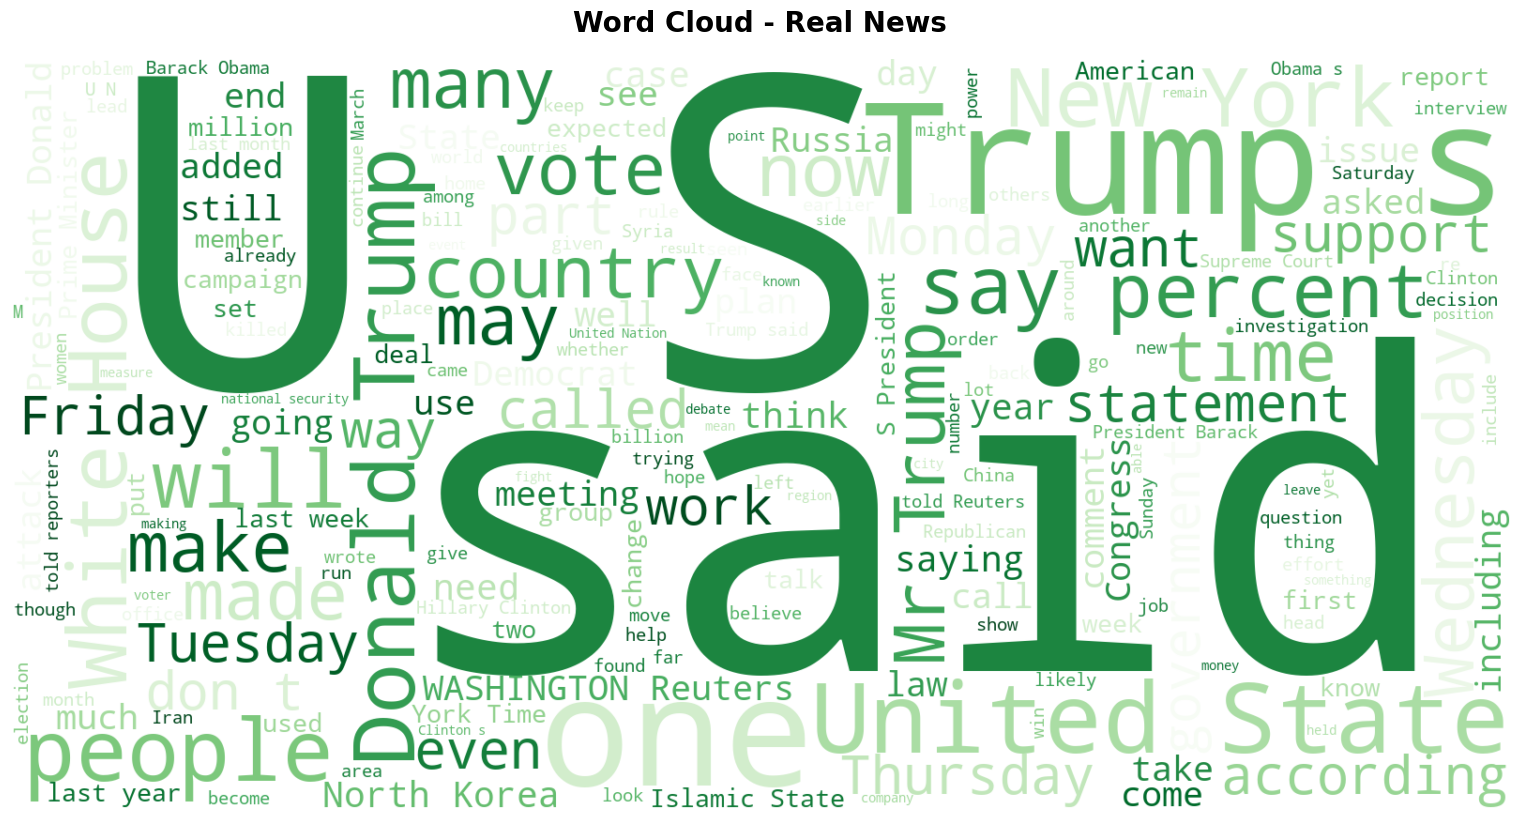

In [6]:
wordcloud_real = WordCloud(
    width=1600, 
    height=800, 
    background_color='white',
    colormap='Greens',
    max_words=200,
    relative_scaling=0.5,
    min_font_size=10
).generate(real_news_text)

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Real News', fontsize=20, fontweight='bold', pad=20)
plt.tight_layout(pad=0)
plt.show()

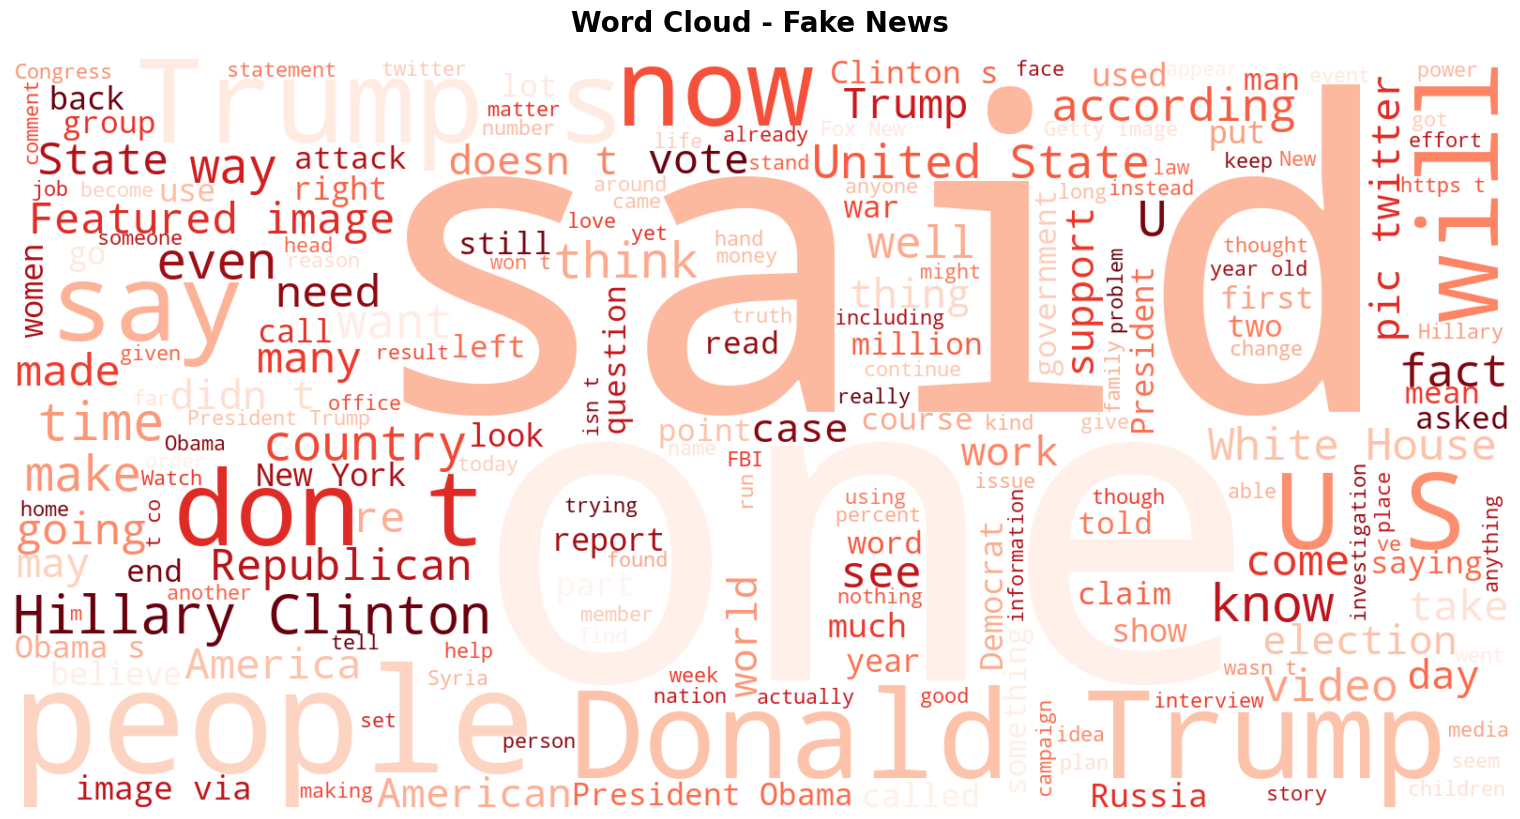

In [7]:
wordcloud_fake = WordCloud(
    width=1600, 
    height=800, 
    background_color='white',
    colormap='Reds',
    max_words=200,
    relative_scaling=0.5,
    min_font_size=10
).generate(fake_news_text)

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Fake News', fontsize=20, fontweight='bold', pad=20)
plt.tight_layout(pad=0)
plt.show()

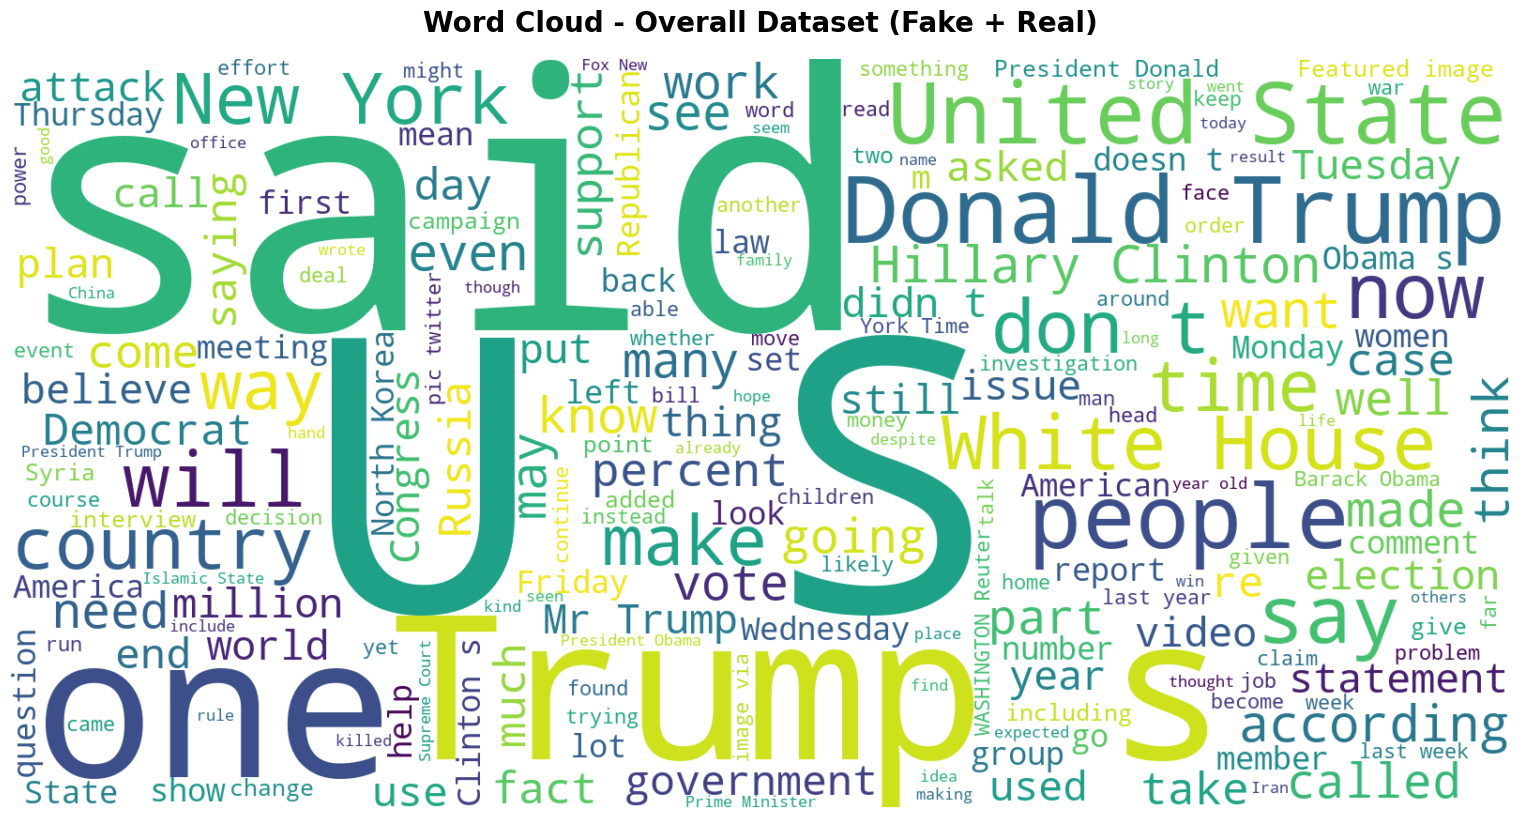

In [8]:
wordcloud_all = WordCloud(
    width=1600, 
    height=800, 
    background_color='white',
    colormap='viridis',
    max_words=200,
    relative_scaling=0.5,
    min_font_size=10
).generate(all_text)

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Overall Dataset (Fake + Real)', fontsize=20, fontweight='bold', pad=20)
plt.tight_layout(pad=0)
plt.show()

### 3.4 Top 20 Most Frequent Words

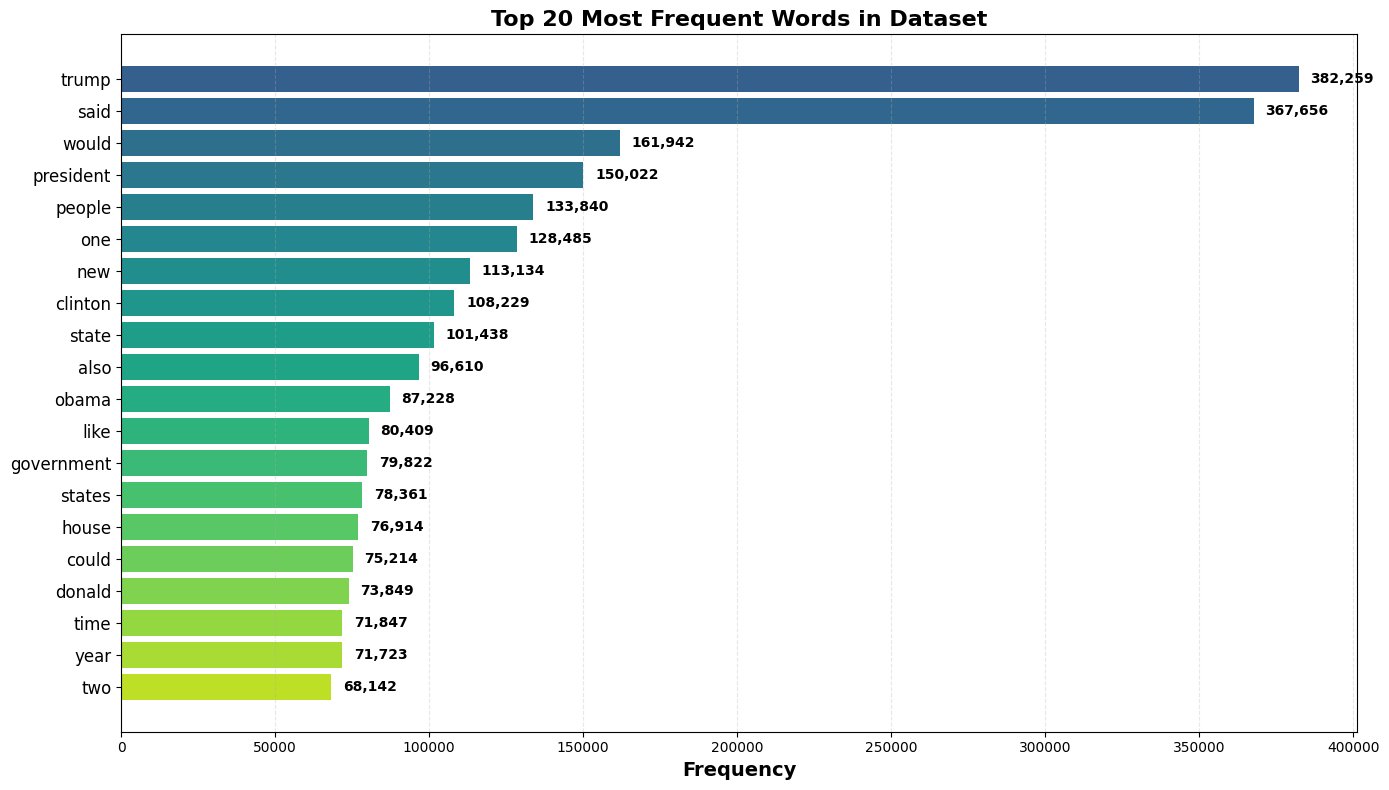

In [9]:
from collections import Counter
import re

def get_words(text):
    words = re.findall(r'\b[a-z]{3,}\b', text.lower())
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if w not in stop_words]
    return words

all_words = get_words(all_text)
word_freq = Counter(all_words)
top_20 = word_freq.most_common(20)

words, counts = zip(*top_20)

plt.figure(figsize=(14, 8))
bars = plt.barh(range(len(words)), counts, color=plt.cm.viridis(np.linspace(0.3, 0.9, len(words))))
plt.yticks(range(len(words)), words, fontsize=12)
plt.xlabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Top 20 Most Frequent Words in Dataset', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()

for i, (bar, count) in enumerate(zip(bars, counts)):
    plt.text(count + max(counts)*0.01, i, f'{count:,}', 
             va='center', fontsize=10, fontweight='bold')

plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

## 3. Data Preprocessing

### Train/Test Split
Split shuffled corpus into stratified train and test partitions.

In [10]:
X = df['full_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Text Cleaning & Lemmatization
Lowercase, strip noise, remove stopwords, and lemmatize tokens.

In [11]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and len(t) > 2]
    
    return ' '.join(tokens)

X_train_processed = X_train.apply(preprocess_text)
X_test_processed = X_test.apply(preprocess_text)

## 4. TF-IDF Vectorization
Convert text to numerical features for traditional ML models

In [ ]:

tfidf = TfidfVectorizer(
    max_features=100000,        # Started with 100 features (terms) to limit complexity | increased to 1000 | increased to 10000 | increased to 100000
    ngram_range=(1, 2),      # Started with unigrams only (single words) | changed to unigrams + bigrams
    min_df=50,              # Started with 100 (consider terms that appear in at least 100 documents) | changed to 50
    max_df=0.95,                                                                                                                                                                                                                                            # Started with 0.9 (remove terms that appear in more than 10% of documents) | changed to 50% | changed to 90%
)
#first with 100 1,1, 100 0.1 -73.29lr 87.82rf
#second test accuracy - 90.75lr 94.39rf 
#third test accuracy -  \ just increasing the fitures by 10 times 95.09lr 96.83% 
#fourth test accuracy -   96.32lr 96.64rf
# fifth test accuracy -  changing to unigram-bigram  96.66lr 96.83%
#sixth fd-50 - y -96.71lr 96.82rf
#seventh - 98.92% 96.95lr 96.50rf

X_train_tfidf = tfidf.fit_transform(X_train_processed)
X_test_tfidf = tfidf.transform(X_test_processed)

print(f"Features: {X_train_tfidf.shape[1]}")

Features: 57402


---
## 5. Model Training & Evaluation
Training 2 traditional ML models: Logistic Regression & Random Forest

In [71]:
results = {}


def evaluate_model(name, model, X_train, y_train, X_test, y_test, train_time):
    y_pred = model.predict(X_test)
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'train_time': train_time,
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }
    print(f"{name} accuracy: {results[name]['accuracy']:.4f} ({results[name]['accuracy']*100:.2f}%)")


### Model 1: Logistic Regression

In [ ]:
start_time = time.time()
lr_model = LogisticRegression(max_iter=2000, n_jobs=-1)
lr_model.fit(X_train_tfidf, y_train)
train_time = time.time() - start_time

evaluate_model('Logistic Regression', lr_model, X_train_tfidf, y_train, X_test_tfidf, y_test, train_time)

Logistic Regression accuracy: 0.9695 (96.95%)


### Model 2: Random Forest

In [ ]:
start_time = time.time()
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=50,
    n_jobs=-1,
    verbose=0
)
rf_model.fit(X_train_tfidf, y_train)
train_time = time.time() - start_time

evaluate_model('Random Forest', rf_model, X_train_tfidf, y_train, X_test_tfidf, y_test, train_time)

Random Forest accuracy: 0.9650 (96.50%)


In [74]:
print("Accuracy after training:")

for name in ['Logistic Regression', 'Random Forest']:

    if name in results:

        acc = results[name]['accuracy']

        print(f"{name}: {acc:.4f} ({acc*100:.2f}%)")

    else:

        print(f"{name}: not computed yet")


Accuracy after training:
Logistic Regression: 0.9695 (96.95%)
Random Forest: 0.9650 (96.50%)


### Save Models to Disk
Store vectorizer and trained classifiers for reuse.

In [75]:
import pickle
import os

os.makedirs('models', exist_ok=True)

with open('models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

with open('models/logistic_regression.pkl', 'wb') as f:
    pickle.dump(lr_model, f)

with open('models/random_forest.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

---
## 6. Comprehensive Model Evaluation & Visualization

In [76]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

model_predictions = {
    'Logistic Regression': {
        'model': lr_model,
        'y_pred': lr_model.predict(X_test_tfidf),
        'y_pred_proba': lr_model.predict_proba(X_test_tfidf)[:, 1]
    },
    'Random Forest': {
        'model': rf_model,
        'y_pred': rf_model.predict(X_test_tfidf),
        'y_pred_proba': rf_model.predict_proba(X_test_tfidf)[:, 1]
    }
}

### 6.1 Logistic Regression - Detailed Evaluation

In [77]:
print("Logistic Regression - Classification Report:")
print(classification_report(y_test, model_predictions['Logistic Regression']['y_pred'], 
                          target_names=['Fake', 'Real'], digits=4))

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

        Fake     0.9652    0.9763    0.9707     12118
        Real     0.9743    0.9623    0.9682     11289

    accuracy                         0.9695     23407
   macro avg     0.9698    0.9693    0.9695     23407
weighted avg     0.9696    0.9695    0.9695     23407



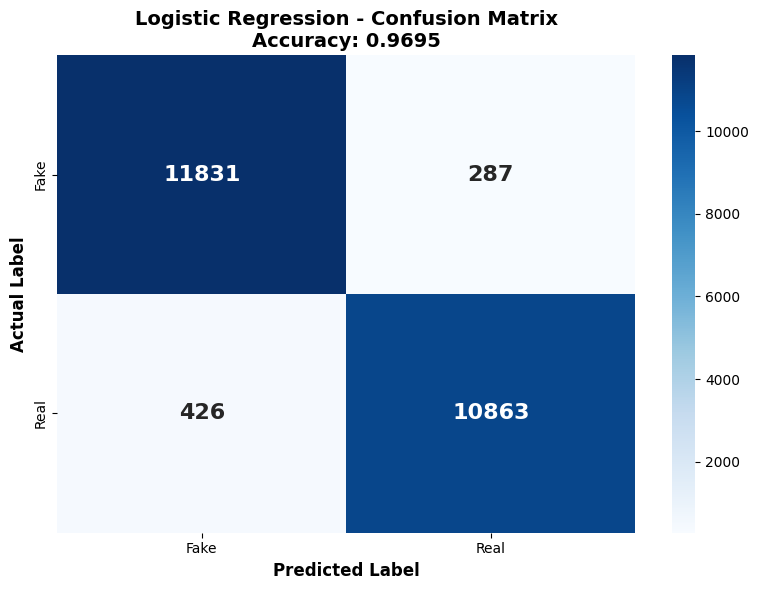

In [78]:
# Logistic Regression - Confusion Matrix
cm_lr = confusion_matrix(y_test, model_predictions['Logistic Regression']['y_pred'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Fake', 'Real'],
            yticklabels=['Fake', 'Real'],
            annot_kws={"size": 16, "weight": "bold"})
plt.title('Logistic Regression - Confusion Matrix\nAccuracy: {:.4f}'.format(
    results['Logistic Regression']['accuracy']), fontsize=14, fontweight='bold')
plt.ylabel('Actual Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

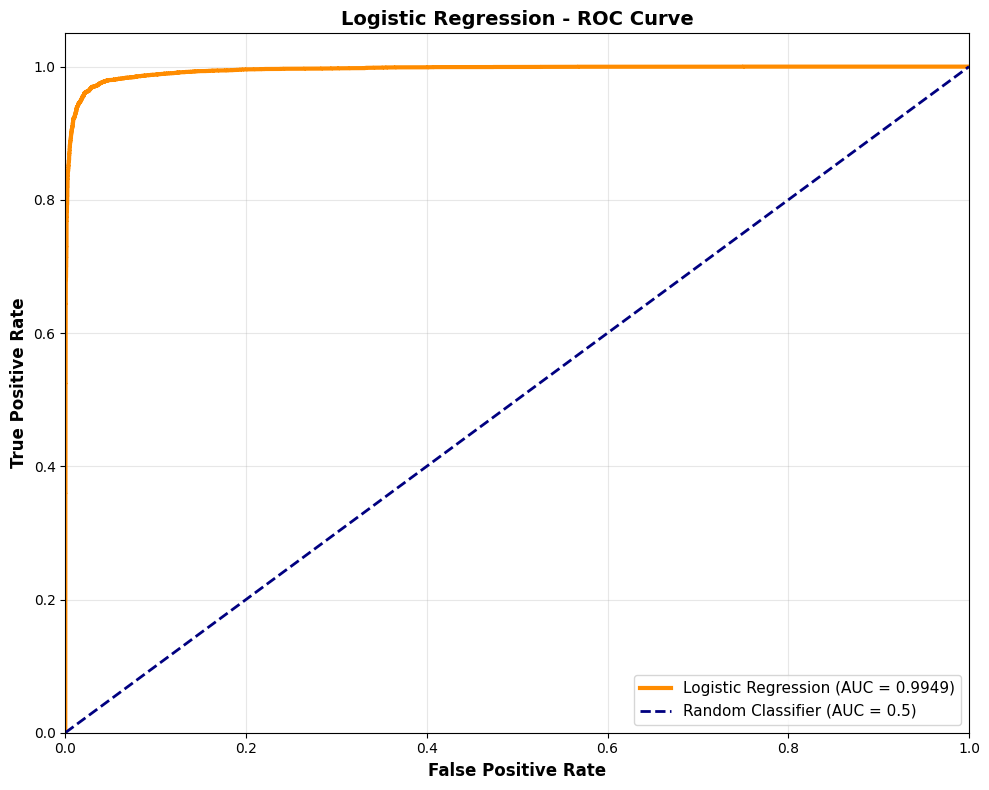

In [79]:
# Logistic Regression - ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, model_predictions['Logistic Regression']['y_pred_proba'])
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=3, 
         label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('Logistic Regression - ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

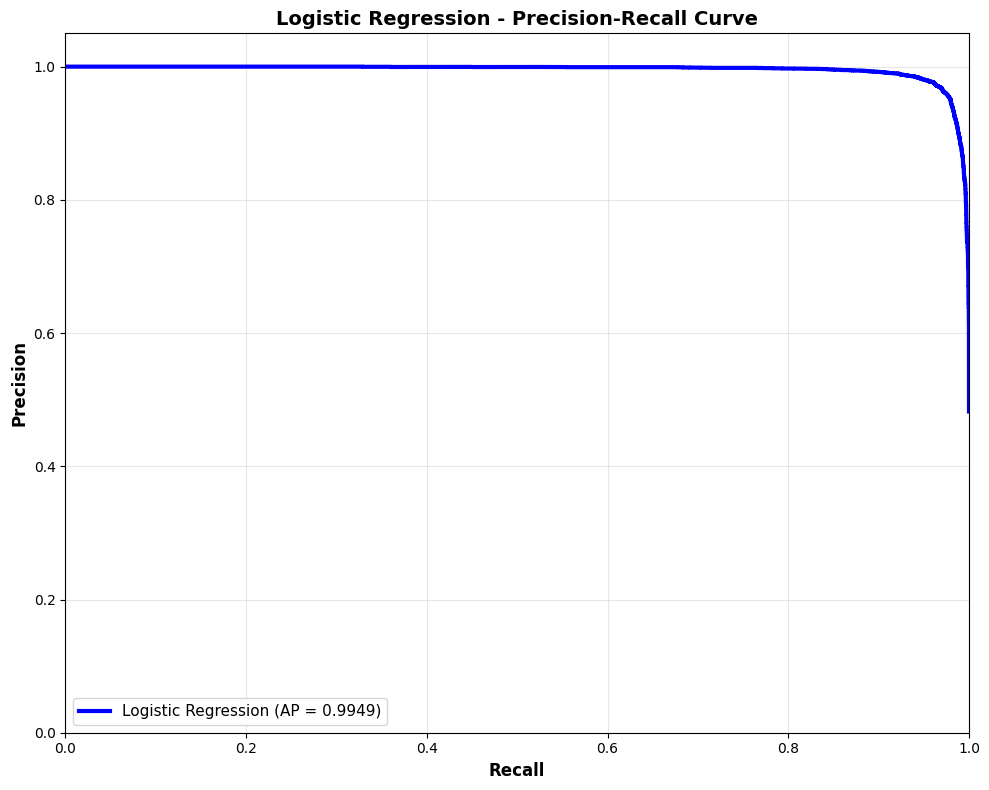

In [80]:
# Logistic Regression - Precision-Recall Curve
precision_lr, recall_lr, _ = precision_recall_curve(y_test, model_predictions['Logistic Regression']['y_pred_proba'])
avg_precision_lr = average_precision_score(y_test, model_predictions['Logistic Regression']['y_pred_proba'])

plt.figure(figsize=(10, 8))
plt.plot(recall_lr, precision_lr, color='blue', lw=3, 
         label=f'Logistic Regression (AP = {avg_precision_lr:.4f})')
plt.xlabel('Recall', fontsize=12, fontweight='bold')
plt.ylabel('Precision', fontsize=12, fontweight='bold')
plt.title('Logistic Regression - Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower left", fontsize=11)
plt.grid(alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.show()

### 6.2 Random Forest - Detailed Evaluation

In [81]:
print("Random Forest - Classification Report:")
print(classification_report(y_test, model_predictions['Random Forest']['y_pred'], 
                          target_names=['Fake', 'Real'], digits=4))

Random Forest - Classification Report:
              precision    recall  f1-score   support

        Fake     0.9502    0.9839    0.9668     12118
        Real     0.9820    0.9446    0.9630     11289

    accuracy                         0.9650     23407
   macro avg     0.9661    0.9643    0.9649     23407
weighted avg     0.9656    0.9650    0.9649     23407



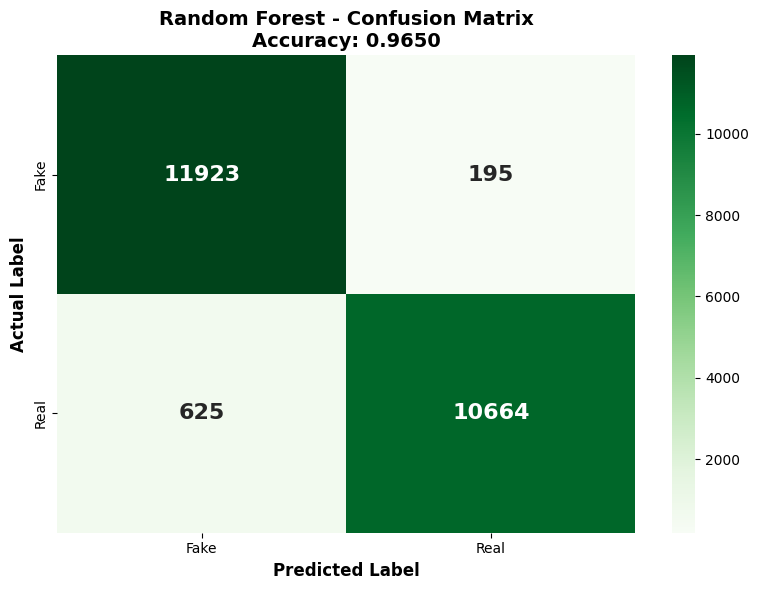

In [82]:
cm_rf = confusion_matrix(y_test, model_predictions['Random Forest']['y_pred'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', cbar=True,
            xticklabels=['Fake', 'Real'],
            yticklabels=['Fake', 'Real'],
            annot_kws={"size": 16, "weight": "bold"})
plt.title('Random Forest - Confusion Matrix\nAccuracy: {:.4f}'.format(
    results['Random Forest']['accuracy']), fontsize=14, fontweight='bold')
plt.ylabel('Actual Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

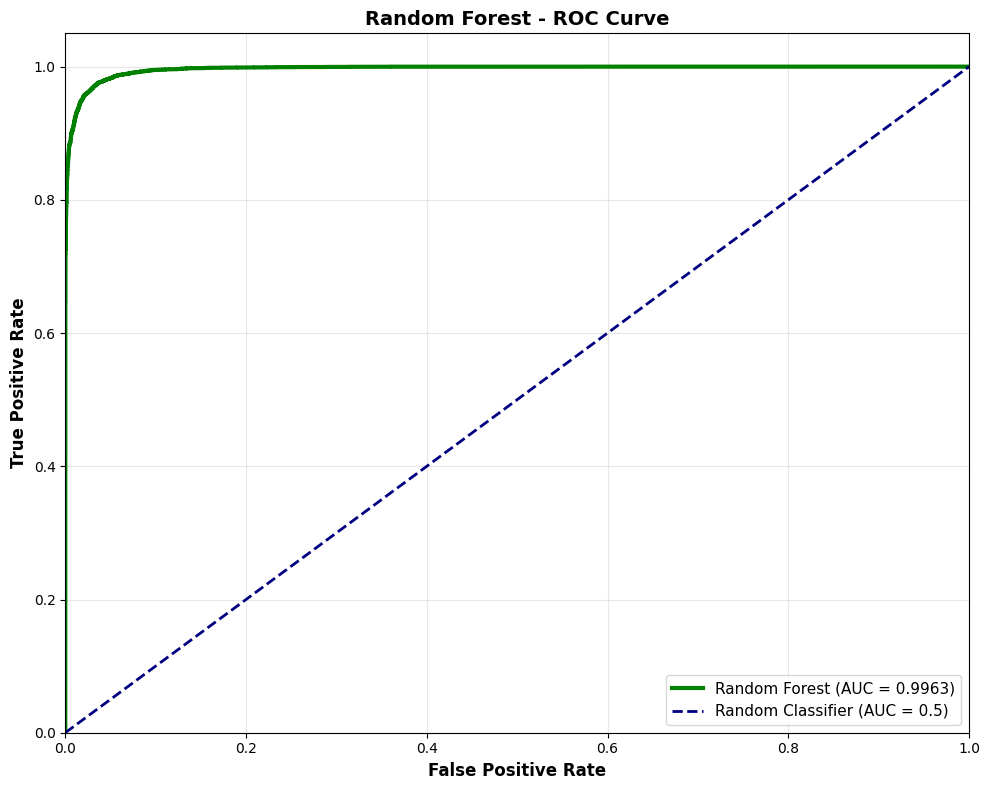

In [83]:
# Random Forest - ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, model_predictions['Random Forest']['y_pred_proba'])
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(10, 8))
plt.plot(fpr_rf, tpr_rf, color='green', lw=3, 
         label=f'Random Forest (AUC = {roc_auc_rf:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('Random Forest - ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

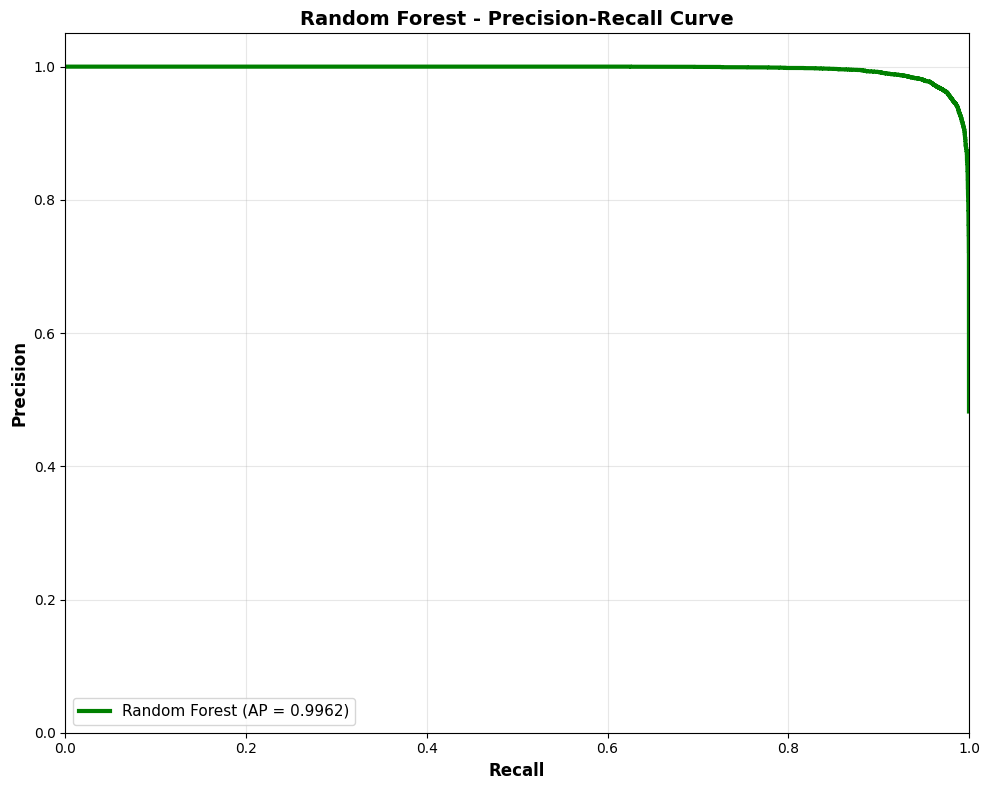

In [84]:
# Random Forest - Precision-Recall Curve
precision_rf, recall_rf, _ = precision_recall_curve(y_test, model_predictions['Random Forest']['y_pred_proba'])
avg_precision_rf = average_precision_score(y_test, model_predictions['Random Forest']['y_pred_proba'])

plt.figure(figsize=(10, 8))
plt.plot(recall_rf, precision_rf, color='green', lw=3, 
         label=f'Random Forest (AP = {avg_precision_rf:.4f})')
plt.xlabel('Recall', fontsize=12, fontweight='bold')
plt.ylabel('Precision', fontsize=12, fontweight='bold')
plt.title('Random Forest - Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower left", fontsize=11)
plt.grid(alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.show()

### 6.3 Comprehensive Model Comparison

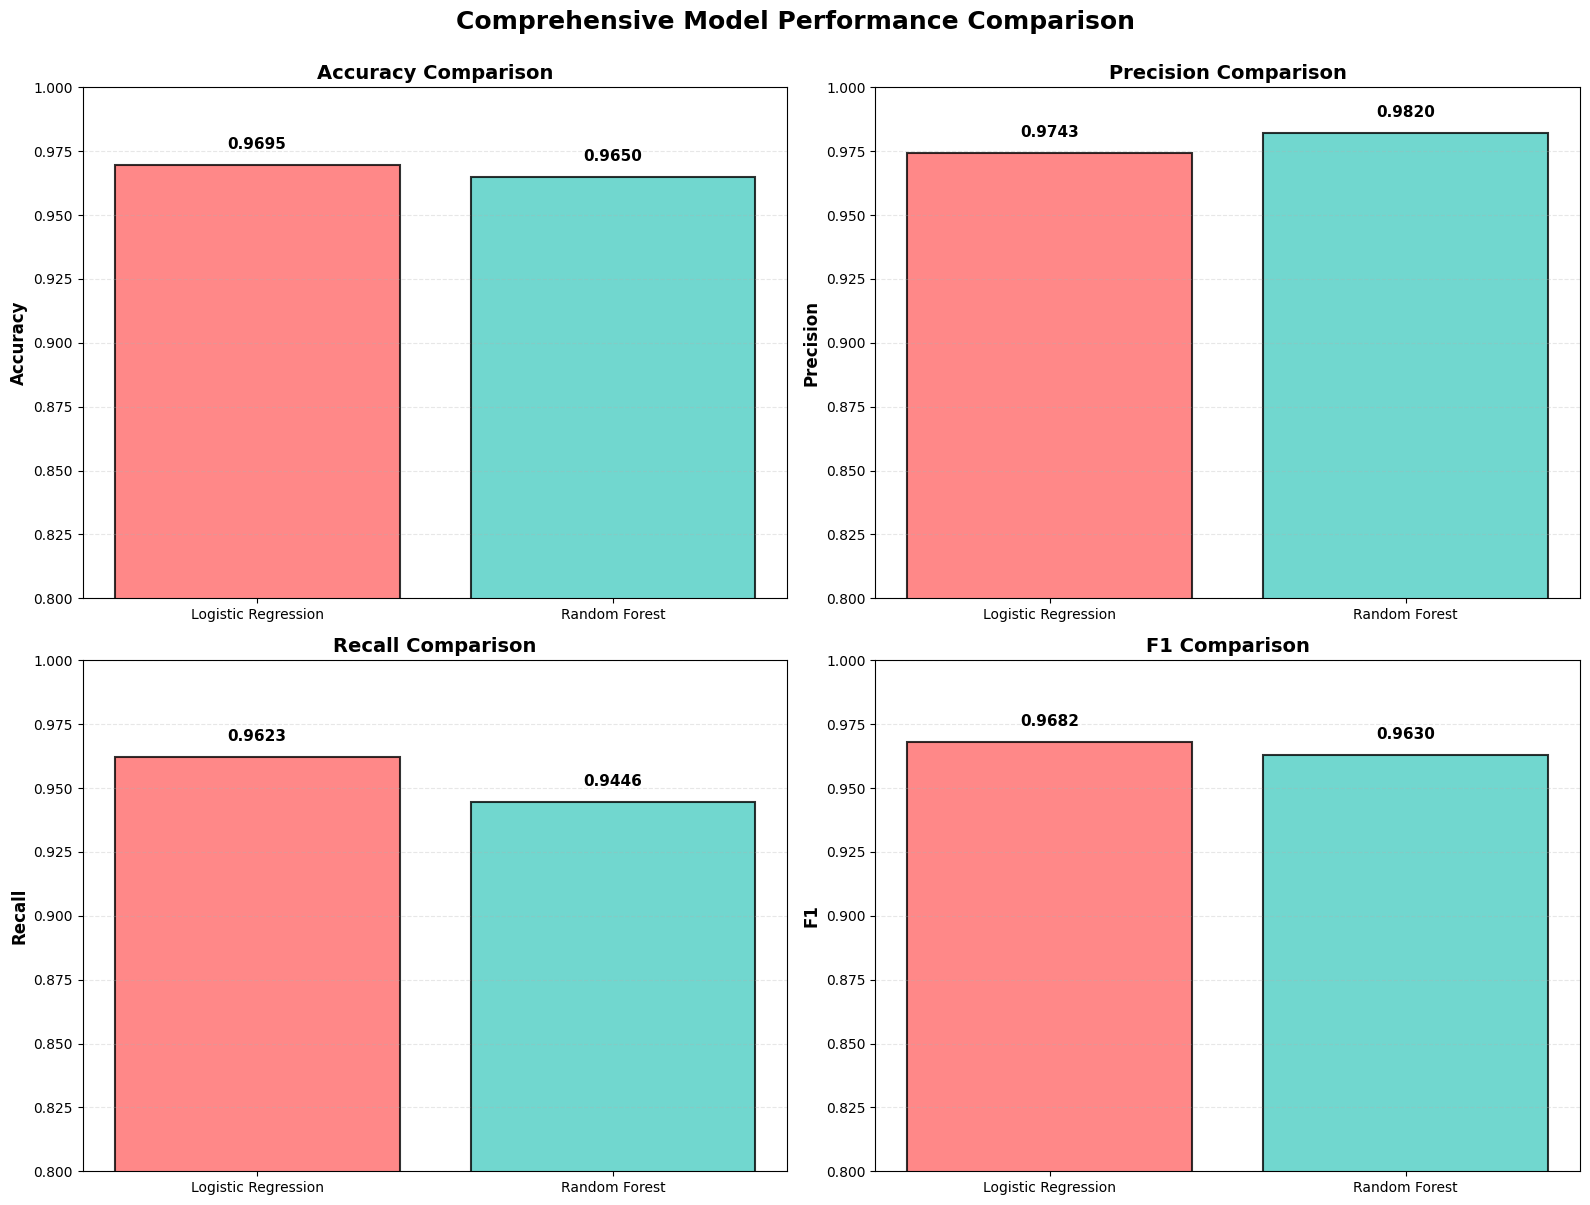

In [85]:
# Comparative Bar Graph - All Metrics
model_names = ['Logistic Regression', 'Random Forest']
metrics_to_compare = ['accuracy', 'precision', 'recall', 'f1']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

colors_map = {'Logistic Regression': '#FF6B6B', 'Random Forest': '#4ECDC4'}

for idx, metric in enumerate(metrics_to_compare):
    values = [results[model][metric] for model in model_names]
    colors = [colors_map[model] for model in model_names]
    
    bars = axes[idx].bar(model_names, values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    axes[idx].set_ylabel(metric.capitalize(), fontsize=12, fontweight='bold')
    axes[idx].set_title(f'{metric.capitalize()} Comparison', fontsize=14, fontweight='bold')
    axes[idx].set_ylim([0.8, 1.0])
    axes[idx].grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height + 0.005,
                      f'{val:.4f}', ha='center', va='bottom', 
                      fontsize=11, fontweight='bold')

plt.suptitle('Comprehensive Model Performance Comparison', fontsize=18, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

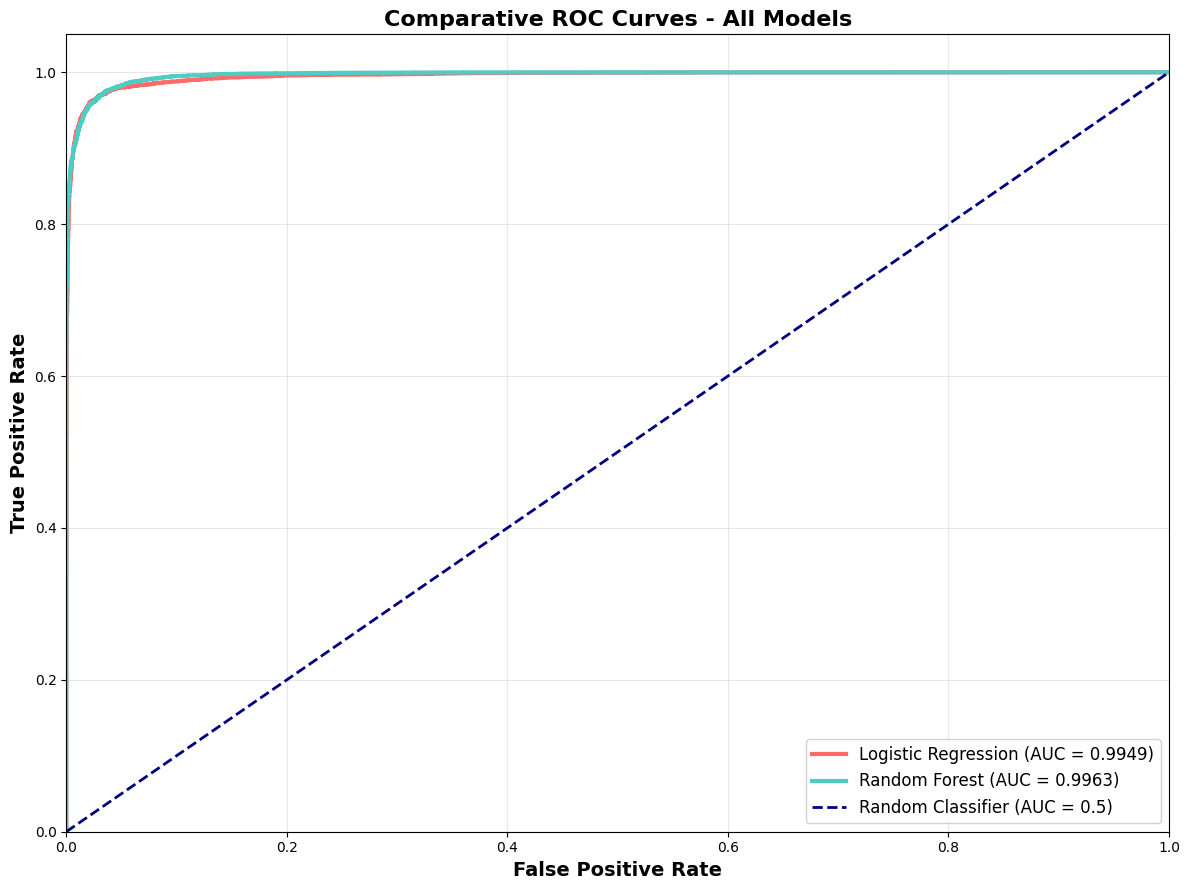

In [86]:
# Comparative ROC Curves - All Models
plt.figure(figsize=(12, 9))

# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, model_predictions['Logistic Regression']['y_pred_proba'])
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, color='#FF6B6B', lw=3, 
         label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})')

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, model_predictions['Random Forest']['y_pred_proba'])
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, color='#4ECDC4', lw=3, 
         label=f'Random Forest (AUC = {roc_auc_rf:.4f})')

# Random classifier baseline
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (AUC = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
plt.title('Comparative ROC Curves - All Models', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12, framealpha=0.9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [87]:
model_names = ['Logistic Regression', 'Random Forest']

fpr_lr, tpr_lr, _ = roc_curve(y_test, model_predictions['Logistic Regression']['y_pred_proba'])
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_rf, tpr_rf, _ = roc_curve(y_test, model_predictions['Random Forest']['y_pred_proba'])
roc_auc_rf = auc(fpr_rf, tpr_rf)

comparison_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': [results[m]['accuracy'] for m in model_names],
    'Precision': [results[m]['precision'] for m in model_names],
    'Recall': [results[m]['recall'] for m in model_names],
    'F1-Score': [results[m]['f1'] for m in model_names],
    'ROC-AUC': [roc_auc_lr, roc_auc_rf],
    'Training Time (s)': [results[m]['train_time'] for m in model_names]
})

print(comparison_df.to_string(index=False))

              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC  Training Time (s)
Logistic Regression  0.969539   0.974260 0.962264  0.968225 0.994870           1.188111
      Random Forest  0.964968   0.982043 0.944636  0.962976 0.996337          18.022172


---
## 8. Key Insights & Recommendations

### 8.1 Best Model Snapshot
Identify the top-performing classifier from the comparison table.

In [88]:
best_model = comparison_df.idxmax()['Accuracy']
best_accuracy = comparison_df.loc[best_model, 'Accuracy']

print(f"\nBest Model: {best_model}")
print(f"Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")


Best Model: 0
Accuracy: 0.9695 (96.95%)


### 8.2 Prediction Utilities
Helpers to score new articles with the trained models.

In [89]:
def _prob_fake_real(model, text_tfidf):
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(text_tfidf)[0]
        if len(probs) == 2:
            if hasattr(model, "classes_"):
                cls = list(model.classes_)
                p_fake = probs[cls.index(0)] if 0 in cls else probs[0]
                p_real = probs[cls.index(1)] if 1 in cls else probs[-1]
            else:
                p_fake, p_real = probs[0], probs[1]
            return float(p_fake), float(p_real)
    if hasattr(model, "decision_function"):
        margin = model.decision_function(text_tfidf)[0]
        p_real = 1.0 / (1.0 + np.exp(-margin))
        p_fake = 1.0 - p_real
        return float(p_fake), float(p_real)
    return 0.5, 0.5


def predict_news(text, model_name='Logistic Regression'):
    processed_text = preprocess_text(text)
    text_tfidf = tfidf.transform([processed_text])
    model_map = {
        'Logistic Regression': lr_model,
        'Random Forest': rf_model
    }
    
    if model_name not in model_map:
        model_name = 'Logistic Regression'
    
    model = model_map[model_name]
    pred = model.predict(text_tfidf)[0]
    result = "REAL" if pred == 1 else "FAKE"
    p_fake, p_real = _prob_fake_real(model, text_tfidf)
    
    print(f"\n{model_name.upper()} PREDICTION:")
    print(f"Prediction: {result}")
    print(f"Confidence: Fake={p_fake*100:.2f}%, Real={p_real*100:.2f}%")
    return result


def predict_all_models(text):
    processed_text = preprocess_text(text)
    text_tfidf = tfidf.transform([processed_text])
    
    model_map = {
        'Logistic Regression': lr_model,
        'Random Forest': rf_model,
    }
    
    summary = {}
    for name, model in model_map.items():
        pred = model.predict(text_tfidf)[0]
        label = 'REAL' if pred == 1 else 'FAKE'
        p_fake, p_real = _prob_fake_real(model, text_tfidf)
        acc = results.get(name, {}).get('accuracy', None)
        
        summary[name] = {
            'prediction': label,
            'p_fake': p_fake,
            'p_real': p_real,
            'accuracy': acc,
        }
        
        acc_display = f" | Accuracy: {acc:.4f}" if acc is not None else ""
        print(f"\n{name.upper()} PREDICTION:")
        print(f"Prediction: {label}")
        print(f"Confidence: Fake={p_fake*100:.2f}%, Real={p_real*100:.2f}%{acc_display}")
    
    return summary


---

## 9. Interactive Testing (Optional)

Test models on custom news articles


In [90]:
sample_text = """
Iran warns it will retaliate if US attacks, as hundreds killed in protests
Iran has warned it will retaliate if attacked by the US, as BBC sources and activists report hundreds of protesters have now been killed in an escalating government crackdown.

"Things here are very, very bad," a source in Tehran said on Sunday. "A lot of our friends have been killed. They were firing live rounds. It's like a war zone, the streets are full of blood. They're taking away bodies in trucks."

The BBC counted about 180 body bags in footage from a morgue near Tehran. The US-based Human Rights Activist News Agency says it has verified the deaths of 495 protesters and 48 security personnel nationwide.

Another 10,600 people have been detained over the fortnight of unrest, the agency says.

The US has threatened to intervene in Iran over the killing of protesters, but on Sunday, US President Donald Trump said that Iranian leaders had called him and that "they want to negotiate".

He added, however, that the US "may have to act before a meeting".

Trump has not elaborated on what the US is considering, but on Sunday he said "we're looking at some very strong options". He has been briefed on options for military strikes on Iran, an official told the BBC's US news partner CBS.

Other approaches could include boosting anti-government sources online, using cyber-weapons against Iran's military, or imposing more sanctions, officials told the Wall Street Journal.

Iran's parliament speaker warned that if the US attacked, both Israel and US military and shipping centres in the region would become legitimate targets.

The protests which began over soaring inflation are now calling for an end to the clerical rule of Iran's Supreme Leader, Ayatollah Ali Khamenei.

Iran's attorney general said anyone protesting would be considered an "enemy of God" - an offence that carries the death penalty - while Khamenei has dismissed demonstrators as a "bunch of vandals" seeking to "please" Trump.

On Sunday the country announced three days of mourning for what it called "martyrs killed in Iranian national battle against the US and Israel".

Staff at several hospitals have told the BBC they have been overwhelmed with dead or injured protesters in recent days.

BBC Persian has verified that 70 bodies were brought to one hospital in the city of Rasht on Friday night, while a health worker at a Tehran hospital told the BBC: "Around 38 people died. Many as soon as they reached the emergency beds... direct shots to the heads of the young people, to their hearts as well. Many of them didn't even make it to the hospital."

The BBC and most other international news organisations are unable to report from inside Iran, and the Iranian government has imposed an internet shutdown since Thursday, making obtaining and verifying information difficult.

Some footage has emerged, including video showing rows of body bags at the Forensic Diagnostic and Laboratory Center of Tehran Province - a morgue in Kahrizak.

In one video from the site, about 180 shrouded or wrapped figures can be seen, the majority lying out in the open. Shouts and cries of distress can be heard from people who appear to be looking for their loved ones.

Footage has been blurred to protect the identities of the living, who could face further persecution from the authorities.

Several videos confirmed as recent by BBC Verify show clashes between protesters and security forces in Mashhad, Iran's second-largest city.

Masked protesters can be seen taking cover behind bins and bonfires, with a row of security forces in the distance. A vehicle that appears to be a bus is engulfed in flames.

Multiple gunshots can be heard, and what sounds like banging on pots and pans.

A figure standing on a nearby footbridge appears to fire multiple gunshots in several directions as a couple of people take cover behind a fence.

In Tehran, a verified video from Saturday night shows protesters taking over the streets in the Gisha district, the sound of banging on pots in Punak Square, and a crowd marching and calling for the end of clerical rule in the Heravi district.
"""

predict_all_models(sample_text)


LOGISTIC REGRESSION PREDICTION:
Prediction: REAL
Confidence: Fake=27.38%, Real=72.62% | Accuracy: 0.9695

RANDOM FOREST PREDICTION:
Prediction: REAL
Confidence: Fake=44.23%, Real=55.77% | Accuracy: 0.9650


{'Logistic Regression': {'prediction': 'REAL',
  'p_fake': 0.27382361711574466,
  'p_real': 0.7261763828842553,
  'accuracy': 0.9695390267868587},
 'Random Forest': {'prediction': 'REAL',
  'p_fake': 0.44234833060053075,
  'p_real': 0.5576516693994692,
  'accuracy': 0.9649677446917588}}